# 6. 교차검증과 그리드서치
* 와인 분류 문제 : 화이트와인, 레드와인 분류하기
* 혼공머신 - p242

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 4-1. 데이터 준비하기
* https://www.kaggle.com/rajyellow46/wine-quality

In [7]:
ori_data = pd.read_csv('data/wine_data.csv')
data = ori_data.copy()
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [8]:
# type 데이터 변경
data.loc[data['type'] == 'white', 'type'] = 1
data.loc[data['type'] == 'red', 'type'] = 0
data['type'] = data['type'].astype(np.int)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int32  
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 634.6 KB


In [10]:
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

### 결측치 제거

In [11]:
data.dropna(inplace=True)

In [12]:
data.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### 상관관계 분석

<AxesSubplot:>

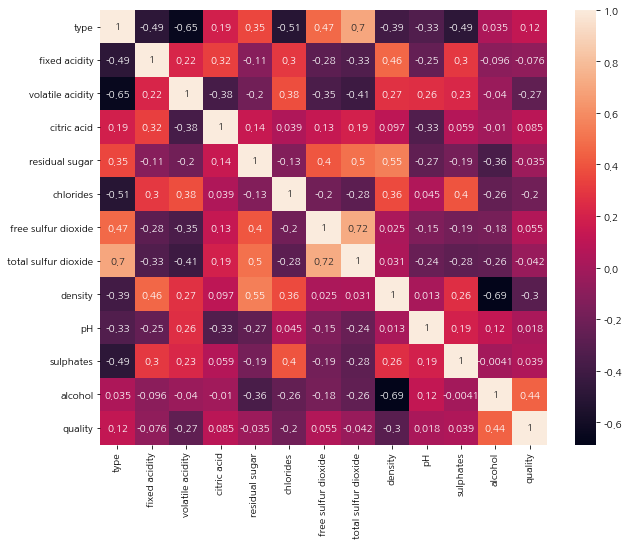

In [13]:
# 상관관계
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot = True)

In [14]:
# 관련있는 특성 추출
data.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [15]:
# 입력데이터 만들기
input_df = data[['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']]
input_df.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,7.0,0.27,20.7,0.045,45.0,170.0,1.0010,3.00,0.45
1,6.3,0.30,1.6,0.049,14.0,132.0,0.9940,3.30,0.49
2,8.1,0.28,6.9,0.050,30.0,97.0,0.9951,3.26,0.44
3,7.2,0.23,8.5,0.058,47.0,186.0,0.9956,3.19,0.40
4,7.2,0.23,8.5,0.058,47.0,186.0,0.9956,3.19,0.40


In [16]:
input_df.shape

(6463, 9)

In [17]:
# 입력데이터는 2차원 배열로 만들기
input_data = input_df.to_numpy()
input_data

array([[ 7.     ,  0.27   , 20.7    , ...,  1.001  ,  3.     ,  0.45   ],
       [ 6.3    ,  0.3    ,  1.6    , ...,  0.994  ,  3.3    ,  0.49   ],
       [ 8.1    ,  0.28   ,  6.9    , ...,  0.9951 ,  3.26   ,  0.44   ],
       ...,
       [ 6.3    ,  0.51   ,  2.3    , ...,  0.99574,  3.42   ,  0.75   ],
       [ 5.9    ,  0.645  ,  2.     , ...,  0.99547,  3.57   ,  0.71   ],
       [ 6.     ,  0.31   ,  3.6    , ...,  0.99549,  3.39   ,  0.66   ]])

In [41]:
# 타겟데이터 만들기
target_data = data['type'].to_numpy()
target_data

array([1, 1, 1, ..., 0, 0, 0])

## 4-2. 데이터 나누기
* 테스트 세트는 모델을 만들고 나서 마지막에 딱 한번만 사용하는 것이 좋음
* but, 테스트 세트를 사용하지 않으면 모델이 과대적합인지 과소적합인지 판단하기 어려움
* 방법은? 훈련 세트를 또 나누어 검증 세트로 만듦
* 검증 세트는 훈련세트의 20% 정도, 하이퍼 파라미터 튜닝용
* 훈련세트에서 모델을 훈련하고 검증세트에서 모델을 평가하며 매개변수를 바꿔가며 가장 좋은 모델을 고름
* 이 매개변수를 사용해 훈련세트와 검증세트를 합쳐 전체 훈련데이터에서 모델을 다시 훈련함
* 마지막 테스트 세트에서 최종 점수를 평가함

In [22]:
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트 나누기
train_input, test_input, train_target, test_target = train_test_split(input_data, target_data, test_size=0.2, stratify=target_data, random_state=42)
train_input.shape, test_input.shape

((5170, 9), (1293, 9))

In [24]:
# 훈련 세트와 검증 세트로 나누기
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, stratify=train_target, random_state=42)
sub_input.shape, val_input.shape

((4136, 9), (1034, 9))

## 4-3. 모델 학습 및 평가

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

DecisionTreeClassifier(random_state=42)

In [26]:
dt.score(sub_input, sub_target)

0.9997582205029013

In [27]:
dt.score(val_input, val_target)

0.9835589941972921

## 4-4. 교차검증(Cross Validation)
* 검증 세트를 떼어내어 평가하는 과정을 여러번 반복함
* 각 폴드에서 계산 검증 점수를 평균함
* 훈련 세트를 세부분으로 나눠서 교차 검증을 수행하는 것을 3-폴드 교차 검증이라고 함 (k개로 나누면 k-폴드 교차검증이 됨)

In [30]:
from sklearn.model_selection import cross_validate

# 훈련 세트 전체를 넘김 (5-폴드 교차 검증)
scores = cross_validate(dt, train_input, train_target)
scores

{'fit_time': array([0.02792239, 0.05983973, 0.05684566, 0.0229373 , 0.02148914]),
 'score_time': array([0.00199771, 0.00099659, 0.        , 0.00099826, 0.        ]),
 'test_score': array([0.97969052, 0.97582205, 0.98452611, 0.97388781, 0.97388781])}

* fit_time : 모델 훈련 시간
* score_time : 모델 검증 시간

In [32]:
# 검증 점수 평균
np.mean(scores['test_score'])

0.9775628626692455

* cross_validate()는 훈련세트를 섞어 폴드를 나누지 않음
* 교차 검증 시 훈련 세트를 섞으려면 분할기(Splitter)를 지정해야 함
* 분류 모델의 분할기: StratifiedKFold, 회귀 모델의 분할기: Kfold

In [35]:
# cross_validate()는 훈련세트를 섞어 폴드를 나누지 않음
# 교차 검증 시 훈련 세트를 섞으려면 분할기(Splitter)를 지정해야 함
# 
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)

In [37]:
scores

{'fit_time': array([0.03291106, 0.05039144, 0.07009411, 0.04188585, 0.03733444,
        0.03123546, 0.04076266, 0.02972293, 0.03124213, 0.03244281]),
 'score_time': array([0.00299311, 0.00101686, 0.00099874, 0.00099826, 0.        ,
        0.        , 0.00099754, 0.        , 0.        , 0.00099802]),
 'test_score': array([0.99032882, 0.98259188, 0.98452611, 0.98259188, 0.98259188,
        0.97678917, 0.99032882, 0.98259188, 0.98452611, 0.99226306])}

In [39]:
np.mean(scores['test_score'])

0.9849129593810446

## 4-5. 그리드 서치(Grid Search)
* 모델파라미터 : 머신러닝 모델이 학습하는 파라미터
* 하이퍼파라미터 : 사용자가 지정해주어야 하는 파라미터
* 라이브러리가 기본적으로 제공하는 매개변수를 바꿔가면서 모델을 훈련하고 교차 검증을 수행해야 함
* GridSearchCV 클래스 : 하이퍼파라미터 탐색과 교차 검증을 한번에 수행함

In [42]:
from sklearn.model_selection import GridSearchCV

# 노드를 분할하기 위한 불순도 감소 최소량을 지정하는 파라미터
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [43]:
# min_impurity_decrease값을 바꿔가며 총 5번 실행 * 5-폴드 교차 검증 = 총 25개의 모델을 훈련
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [44]:
# 25개의 모델 중 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련세트에서 다시 모델을 훈련함
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [45]:
dt = gs.best_estimator_
dt.score(train_input, train_target)

0.995357833655706

In [46]:
# 최적의 파라미터
gs.best_params_

{'min_impurity_decrease': 0.0002}

In [50]:
# 5-폴드 교차검증의 평균 점수
# 두번째 파라미터의 교차 검증 평균 점수가 높음
gs.cv_results_['mean_test_score']

array([0.9787234 , 0.98027079, 0.97969052, 0.97930368, 0.97969052])

In [49]:
np.max(gs.cv_results_['mean_test_score'])

0.9802707930367506

In [60]:
dt.score(test_input, test_target)

0.9876256767208044

### max_depth(트리깊이), min_samples_split(노드를 나누기 위한 최소 샘플 수) 최적의 파라미터 찾기

In [52]:
params = {
    'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
    'max_depth': np.arange(5, 20, 1),
    'min_samples_split': np.arange(2, 100, 10)
}
params

{'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
        0.0009]),
 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 'min_samples_split': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92])}

* min_impurity_decrease : 9개
* max_depth : 15개
* min_samples_split : 10개
* 9 * 15 * 10 * 5-폴드 = 6750개

In [54]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [56]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92])})

In [57]:
# 최적의 매개변수
gs.best_params_

{'max_depth': 8, 'min_impurity_decrease': 0.0002, 'min_samples_split': 2}

In [58]:
# 최상의 교차 검증 점수
gs.cv_results_['mean_test_score']

array([0.97891683, 0.97640232, 0.97601547, ..., 0.97427466, 0.97369439,
       0.97253385])

In [59]:
np.max(gs.cv_results_['mean_test_score'])

0.9806576402321083

In [61]:
dt = gs.best_estimator_
dt.score(test_input, test_target)

0.9891724671307038